In [1]:
%matplotlib inline

In [2]:
from io import StringIO
from matplotlib import pyplot as plt
import os
import csv
import numpy as np
import pandas as pd
import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
with open("tree_info_local.pkl", 'rb') as f:
    tree_info_local = pickle.load(f)

tree_info_local["time"] -= tree_info_local["time"][0]
max_range = tree_info_local["range"].max()
tree_info_local = tree_info_local[tree_info_local["range"] == max_range]
tree_info_local["time"] -= tree_info_local["time"].iloc[0]


with open("network.pickle", "rb") as f:
    ((tree_info5, model_replace5), (tree_info10, model_replace10)) = pickle.load(f)

In [6]:
def plot(num_nodes, tree_info, tree_info_local, axs):
    for i, field in enumerate(["true-z", "auprc", "tree-id"]):
        if len(axs) > i:
            ax = axs[i]
        else:
            plt.figure(figsize=(10, 6))
            ax=plt.subplot(111)
            axs.append(ax)
        if tree_info_local is not None:
            tree_info_local = tree_info_local.rename(columns={
                field: field + "-local"
            })
            tree_info_local.plot(
                x="time", y=field + "-local",
                grid=True,
                ax=ax, title=field
            );
        for i in range(num_nodes):
            df = tree_info[tree_info["node"] == i]
            df = df.rename(columns={
                field: field + "-node-%d" % num_nodes
            })
            if df.shape[0]:
                df.plot(
                    x="time", y=field + "-node-%d" % num_nodes,
                    grid=True,
                    ax=ax, title=field
                );

        ax.set_xlim(0, 600)
        if field == "tree-id":
            ax.set_ylim(0, 500)
    return axs

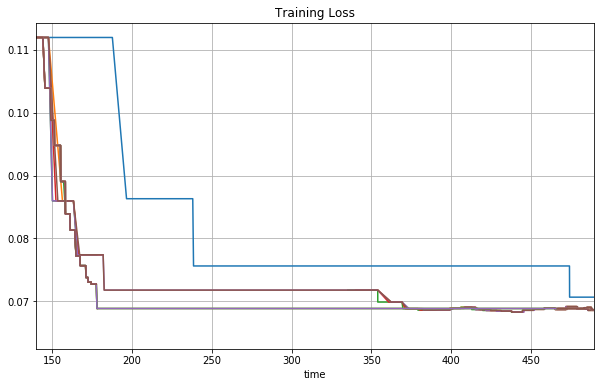

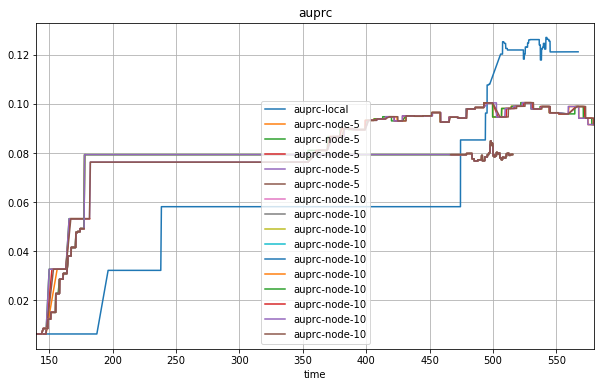

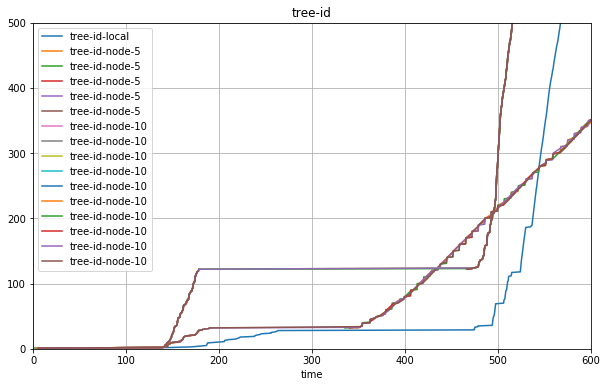

In [16]:
axs = plot(5, tree_info5, tree_info_local, []);
plot(10, tree_info10, None, axs);
axs[0].set_xlim([140, 490])
axs[1].set_xlim([140, 580])
axs[0].legend_ = None
axs[0].set_title("Training Loss");

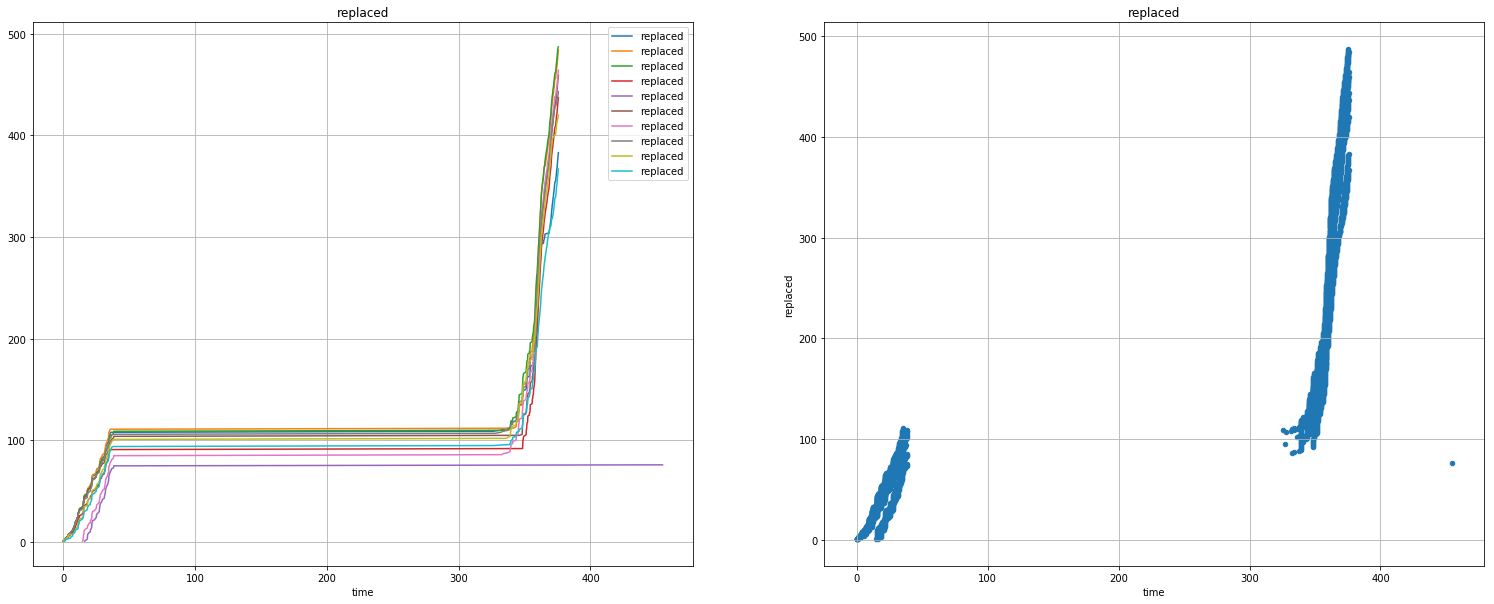

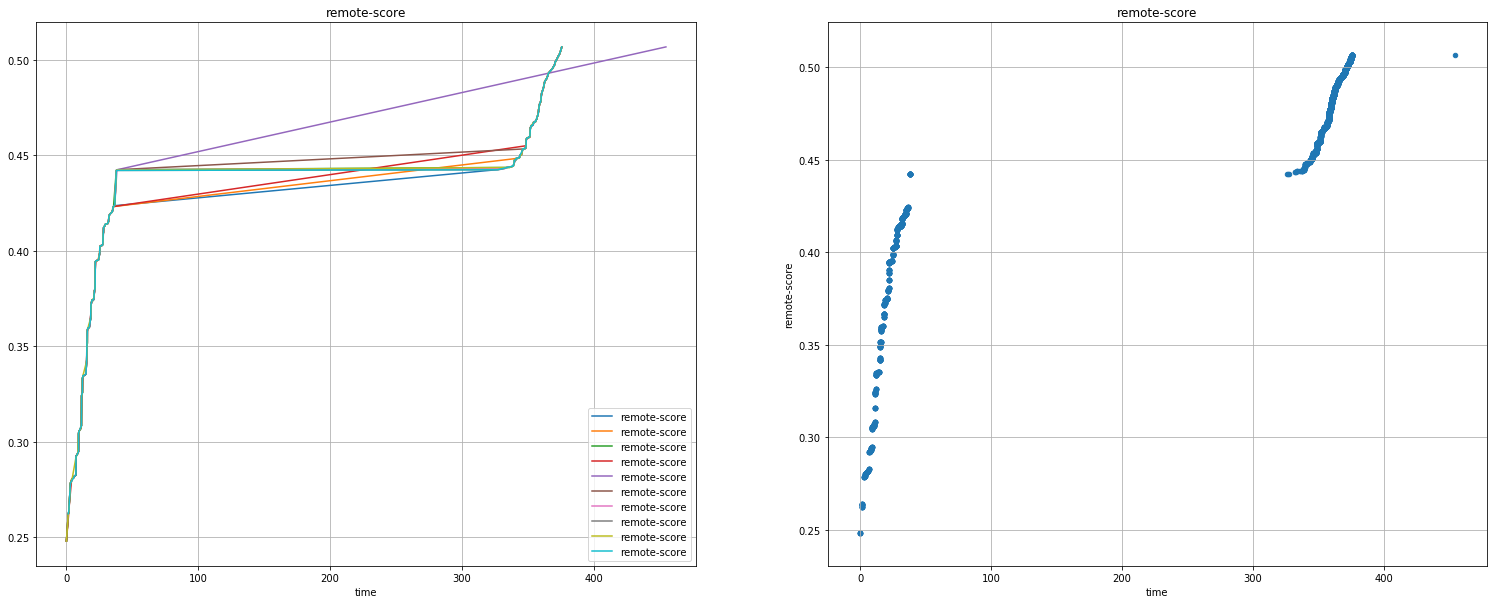

In [6]:
N = 10
model_replace = model_replace10

model_replace["time"] -= model_replace["time"].iloc[0]
for field in ["replaced", "remote-score"]:
    plt.figure(figsize=(26, 10))
    ax1 = plt.subplot(121)
    ax2=plt.subplot(122)
    for i in range(N):
        df = model_replace[model_replace["node"] == i]
        df["replaced"] = 1
        df["replaced"] = df["replaced"].cumsum()
        if df.shape[0]:
            df.plot(
                x="time", y=field,
                grid=True,
                ax=ax1, title=field
            );
            df.plot(
                kind="scatter",
                x="time", y=field,
                grid=True,
                ax=ax2, title=field
            );

## Create pickle files

Run following cells only if new logs are generated.

In [22]:
def create_dataframe(csv_string, col_names): #  sep=",(?![^{]*\})",
    return pd.read_csv(StringIO(csv_string),
                       names=col_names, header=None)


def filter_logs(csv_file, keyword):
    with open(csv_file) as f:
        return ''.join([line for line in f if keyword in line]).strip()


def remove_dict(raw_input):
    assert('"' in raw_input)
    return '\n'.join([
        line[:line.find(', "')].strip() for line in raw_input.split('\n')
    ])


def get_new_tree_info(log_file):
    logs = filter_logs(log_file, "new-tree-info")
    # logs = remove_dict(logs)

    formatted = []
    for line in logs.split('\n'):
        line = line.strip()
        line = line[:line.find('"')]
        formatted.append(line)
    logs = '\n'.join(formatted)
    print(formatted[0])
    cols = ["level", "time", "module", "log-type",
            "tree-id", "num-scanned", "gamma", "sum-gamma-squared"]  # , "tree"]
    return create_dataframe(logs, cols)


def get_performance(log_file):
    logs = filter_logs(log_file, "boosting_speed")

    cols = ["level", "time", "module", "log-type",
            "overall-duration", "overall-count", "overall-speed",
            "learner-duration", "learner-count", "learner-speed"]
    return create_dataframe(logs, cols)


def get_true_z(log_file):
    logs = filter_logs(log_file, "validate-only")

    cols = ["level", "time", "module", "log-type",
            "tree-id", "true-z", "auprc"]
    return create_dataframe(logs, cols)

def get_network_out(log_file):
    logs = filter_logs(log_file, "network-to-send-out")

    cols = ["level", "time", "module", "log-type",
            "local-name", "local-index", "score"]
    return create_dataframe(logs, cols)

def get_network_in(log_file):
    logs = filter_logs(log_file, "message-received")
    logs = remove_dict(logs)
    cols = ["level", "time", "module", "log-type",
            "local-name", "local-index", "remote-name", "remote-idx",
            "remote-ip", "score", "json-len"]  # , "model"]
    return create_dataframe(logs, cols)

def get_model_replace(log_file):
    logs = filter_logs(log_file, "model-replaced")

    cols = ["level", "time", "module", "log-type",
            "remote-score", "local-score", "remote-model-len", "local-model-len"]
    return create_dataframe(logs, cols)

def get_df(base_path, num_nodes):
    trees = []
    speed = []
    true_z = []

    network_in = []
    network_out = []
    model_replace = []

    for i in range(num_nodes):
        log_path = os.path.join(base_path, "node-%d/run-network.log" % i)
        validate_path = os.path.join(base_path, "node-%d/validate.log" % i)

        _trees = get_new_tree_info(log_path)
        # _trees["estimated-z"] = np.exp(-(_trees["gamma"]**2).cumsum())
        _trees["node"] = i
        trees.append(_trees)

        _speed = get_performance(log_path)
        _speed["node"] = i
        speed.append(_speed)

        _true_z = get_true_z(validate_path)
        _true_z["node"] = i
        true_z.append(_true_z)

        _network_in = get_network_in(log_path)
        _network_in["node"] = i
        network_in.append(_network_in)

        _network_out = get_network_out(log_path)
        _network_out["node"] = i
        network_out.append(_network_out)

        _model_replace = get_model_replace(log_path)
        _model_replace["node"] = i
        model_replace.append(_model_replace)

    trees = pd.concat(trees)
    speed = pd.concat(speed)
    true_z = pd.concat(true_z)

    network_in = pd.concat(network_in)
    network_out = pd.concat(network_out)
    model_replace = pd.concat(model_replace)

    print(trees.head())
    trees["estimated-z"] = np.exp(-trees["sum-gamma-squared"])
    trees = trees.drop(columns=["level", "module", "log-type", "sum-gamma-squared"])
    true_z = true_z.drop(columns=["level", "module", "log-type", "time"])
    speed = speed.drop(columns=["level", "module", "log-type"])

    network_in = network_in.drop(columns=["level", "module", "log-type"])
    network_out = network_out.drop(columns=["level", "module", "log-type"])
    model_replace = model_replace.drop(columns=["level", "module", "log-type"])

    tree_info = trees.merge(true_z, on=["tree-id", "node"], how="outer") \
                 .merge(
                     model_replace.rename(columns={"remote-model-len": "tree-id"}),
                     on=["tree-id", "node"], how="outer"
                 ) \
                 .sort_values(by=['node', 'tree-id'])
    tree_info["time"] = tree_info["time_x"].fillna(tree_info["time_y"])
    # tree_info["time"] -= tree_info["time"].iloc[0]
    tree_info = tree_info.drop(
        columns=["time_x", "time_y"])
    tree_info[["estimated-z", "true-z", "auprc"]] = \
        tree_info[["estimated-z", "true-z", "auprc"]].fillna(method="pad")

    return (trees, tree_info, model_replace)


# trees5, tree_info5, model_replace5 = get_df("../logs-analysis/network/10-nodes", 10)
trees10, tree_info10, model_replace10 = get_df("../logs-analysis/network/new-10-nodes", 10)

with open("network.pickle", "wb") as f:
    pickle.dump(
        ((trees5, tree_info5, model_replace5), (trees10, tree_info10, model_replace10)), f
    )

DEBUG, 2668445.607792097, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668446.206792161, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668446.662712248, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668447.204875906, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668447.758469163, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668448.276694904, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668448.876328774, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668449.400489179, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668449.961484864, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
DEBUG, 2668450.563544027, rust_boost::boosting, new-tree-info, 1, 10000, 0.4968, 0.24681024, 
              level                   time          module  

TypeError: bad operand type for unary -: 'str'

In [ ]:
trees10.head()

In [13]:
tree_info5.head()

,tree-id,num-scanned,gamma,node,estimated-z,true-z,auprc,remote-score,local-score,local-model-len,time
0,1,10000.0,0.4968,0,0.781289,0.111951,0.006288,NaN,NaN,NaN,1.014435e+06
1002,2,NaN,NaN,0,0.781289,0.111951,0.006288,0.247926,0.246810,1.0,1.014575e+06
1003,3,NaN,NaN,0,0.781289,0.111951,0.006288,0.262224,0.247926,2.0,1.014576e+06
1004,4,NaN,NaN,0,0.781289,0.111951,0.006288,0.263128,0.262224,3.0,1.014577e+06
1005,5,NaN,NaN,0,0.781289,0.111951,0.006288,0.264104,0.263128,4.0,1.014577e+06


In [14]:
trees5.head()

,time,tree-id,num-scanned,gamma,node,estimated-z
0,1.014435e+06,1,10000,0.496800,0,0.781289
1,1.014587e+06,33,47000,0.019771,0,0.716250
2,1.014602e+06,75,34000,0.010507,0,0.668496
3,1.014602e+06,77,311000,0.010507,0,0.668155
4,1.014605e+06,88,32000,0.009456,0,0.660981


In [18]:
trees10.sort_values(["node", "tree-id"]).head()

,time,tree-id,num-scanned,gamma,node,estimated-z
DEBUG,rust_boost::boosting,10000,0.496800,0.246810,0,0.940903
DEBUG,rust_boost::boosting,10000,0.011385,0.475034,0,0.797992
DEBUG,rust_boost::boosting,10000,0.010246,0.484501,0,0.790776
DEBUG,rust_boost::boosting,10000,0.010246,0.485026,0,0.790373
DEBUG,rust_boost::boosting,10000,0.010246,0.490988,0,0.785788


In [16]:
tree_info10.head()

,tree-id,num-scanned,gamma,node,estimated-z,true-z,auprc,remote-score,local-score,local-model-len,time
3740,1,NaN,NaN,0,NaN,0.111953,0.006288,NaN,NaN,NaN,NaN
4708,2,NaN,NaN,0,NaN,0.111953,0.006288,0.273714,0.246810,1.0,2.66851e+06
4709,3,NaN,NaN,0,NaN,0.111953,0.006288,0.288012,0.273714,2.0,2.66852e+06
4710,5,NaN,NaN,0,NaN,0.111953,0.006288,0.298272,0.288891,4.0,2.66852e+06
4711,7,NaN,NaN,0,NaN,0.111953,0.006288,0.313147,0.298849,6.0,2.66852e+06
